In [309]:
import os 
import numpy as np 
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime

## Importin S&P500 Data

In [290]:
df = pd.read_csv('SP500.csv')

In [291]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Jun 07, 2021","4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,"Jun 04, 2021","4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,"Jun 03, 2021","4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,"Jun 02, 2021","4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,"Jun 01, 2021","4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"


In [292]:
df.describe()

,Date,Open,High,Low,Close*,Adj Close**,Volume
count,1258,1258,1258,1258,1258,1258,1258
unique,1258,1248,1252,1251,1252,1252,1257
top,"Mar 21, 2017","2,832.41","2,271.78","2,160.39","2,268.90","2,268.90","3,884,480,000"
freq,1,2,2,2,2,2,2


In [293]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         1258 non-null   object
 1   Open         1258 non-null   object
 2   High         1258 non-null   object
 3   Low          1258 non-null   object
 4   Close*       1258 non-null   object
 5   Adj Close**  1258 non-null   object
 6   Volume       1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [294]:
df.isnull().sum()


# no null values present

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

## Data Preparation

Renaming Close and Adj Close columns


In [295]:
df = df.rename(columns={"Close*":"close","Adj Close**":"adj_close"})

Converting date column to date values.

In [296]:
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2021-06-07,"4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,2021-06-04,"4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,2021-06-03,"4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,2021-06-02,"4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,2021-06-01,"4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"
...,...,...,...,...,...,...,...
1253,2016-06-14,"2,076.65","2,081.30","2,064.10","2,075.32","2,075.32","3,759,770,000"
1254,2016-06-13,"2,091.75","2,098.12","2,078.46","2,079.06","2,079.06","3,392,030,000"
1255,2016-06-10,"2,109.57","2,109.57","2,089.96","2,096.07","2,096.07","3,515,010,000"
1256,2016-06-09,"2,115.65","2,117.64","2,107.73","2,115.48","2,115.48","3,290,320,000"


Converting the other columns to float

In [297]:
    df.iloc[:]

,Date,Open,High,Low,close,adj_close,Volume
0,2021-06-07,"4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,2021-06-04,"4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,2021-06-03,"4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,2021-06-02,"4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,2021-06-01,"4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"
...,...,...,...,...,...,...,...
1253,2016-06-14,"2,076.65","2,081.30","2,064.10","2,075.32","2,075.32","3,759,770,000"
1254,2016-06-13,"2,091.75","2,098.12","2,078.46","2,079.06","2,079.06","3,392,030,000"
1255,2016-06-10,"2,109.57","2,109.57","2,089.96","2,096.07","2,096.07","3,515,010,000"
1256,2016-06-09,"2,115.65","2,117.64","2,107.73","2,115.48","2,115.48","3,290,320,000"


In [298]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
'en_US.UTF-8'

'en_US.UTF-8'

In [299]:
for i in range(1,7):
    df.iloc[:,i]=df.iloc[:,i].apply(lambda x: float(x.replace(',','')))

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   close      1258 non-null   float64       
 5   adj_close  1258 non-null   float64       
 6   Volume     1258 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.9 KB


## Visualising Time Series Data

In [301]:
sns.set(rc={'figure.figsize':(14,6)})

Date
Open


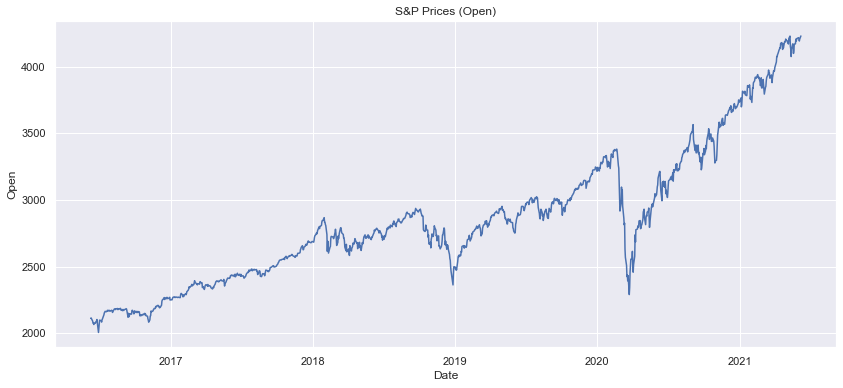

High


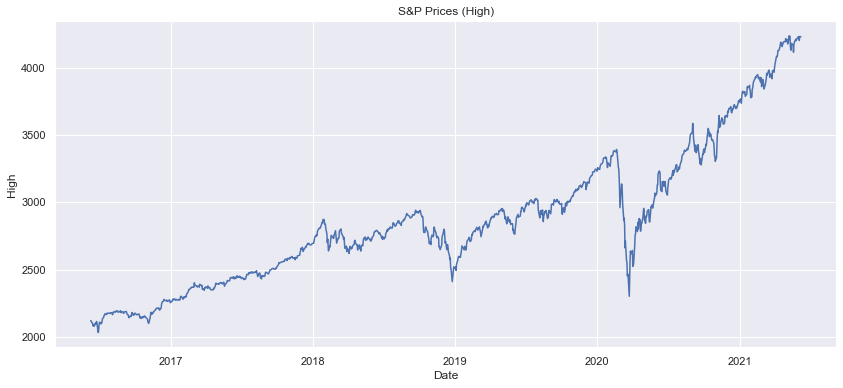

Low


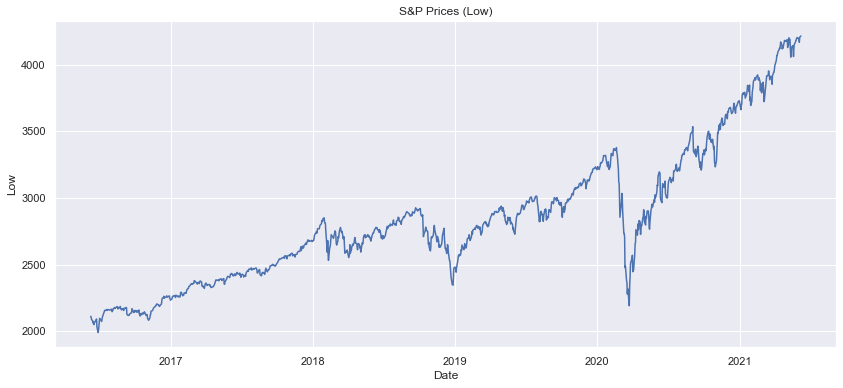

close


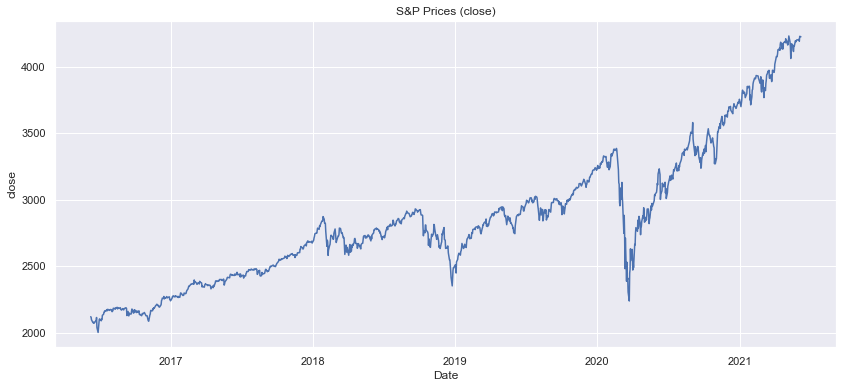

adj_close


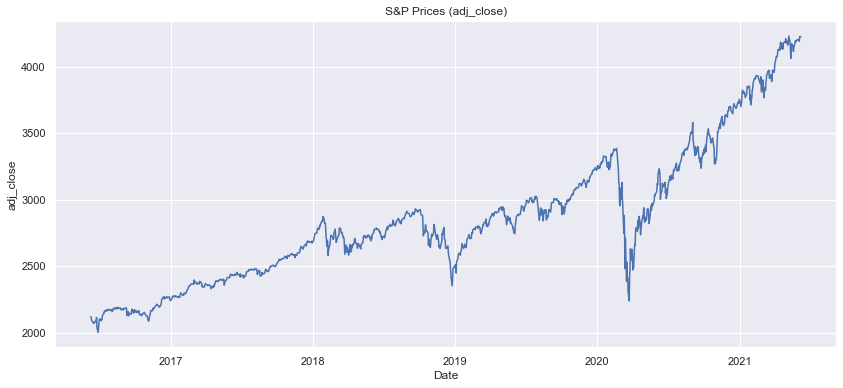

Volume


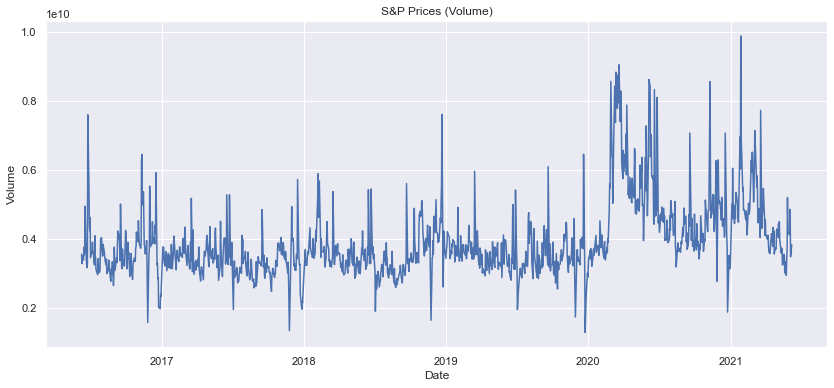

In [302]:
sns.set_theme(style="darkgrid")
for column in list(df.columns):
    print(column)
    if column != "Date":
        sns.lineplot(x="Date", y=column, data=df).set_title("S&P Prices (" + column + ")")
        plt.show()
        

In [303]:
df = df.iloc[::-1].reset_index()

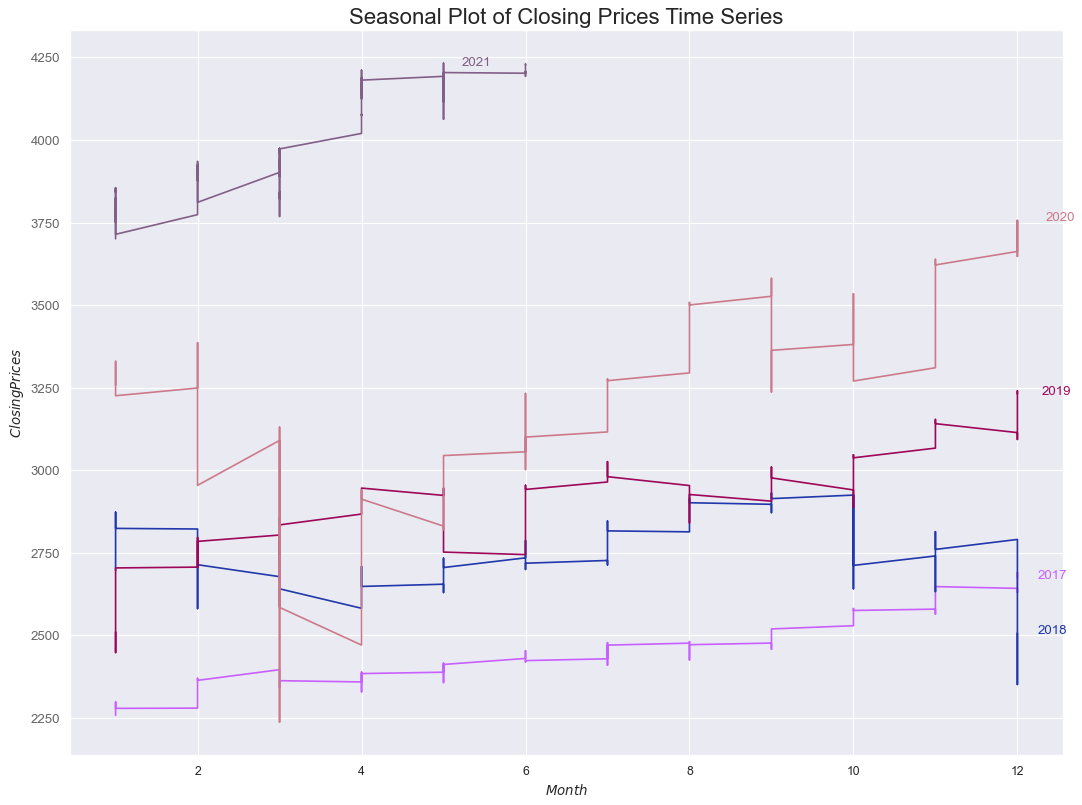

In [304]:
# Seasonal Plot

df['year'] = [d.year for d in df.Date]
df['month'] = [d.month for d in df.Date]
years = df['year'].unique()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)


plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:                
        plt.plot('month', 'close', data=df.loc[df.year==y, :], color=mycolors[i])
        plt.text(df.loc[df.year==y, :].shape[0]/20.5, df.loc[df.year==y, 'close'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(ylabel='$Closing Prices$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Closing Prices Time Series", fontsize=20)
plt.show()

In [305]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [306]:
df.corr()

,index,Open,High,Low,close,adj_close,Volume,year,month
index,1.000000,-0.914588,-0.919383,-0.908461,-0.914205,-0.914205,-0.415103,-0.981411,0.091424
Open,-0.914588,1.000000,0.999512,0.999170,0.998813,0.998813,0.261795,0.902112,-0.107580
High,-0.919383,0.999512,1.000000,0.998768,0.999267,0.999267,0.273622,0.907404,-0.110930
Low,-0.908461,0.999170,0.998768,1.000000,0.999354,0.999354,0.241261,0.895624,-0.104525
close,-0.914205,0.998813,0.999267,0.999354,1.000000,1.000000,0.255953,0.901986,-0.108644
adj_close,-0.914205,0.998813,0.999267,0.999354,1.000000,1.000000,0.255953,0.901986,-0.108644
Volume,-0.415103,0.261795,0.273622,0.241261,0.255953,0.255953,1.000000,0.435259,-0.182921
year,-0.981411,0.902112,0.907404,0.895624,0.901986,0.901986,0.435259,1.000000,-0.280155
month,0.091424,-0.107580,-0.110930,-0.104525,-0.108644,-0.108644,-0.182921,-0.280155,1.000000


## Choosing Target Variables

We will conduct the timeseries analysis on the adjusted closing price.

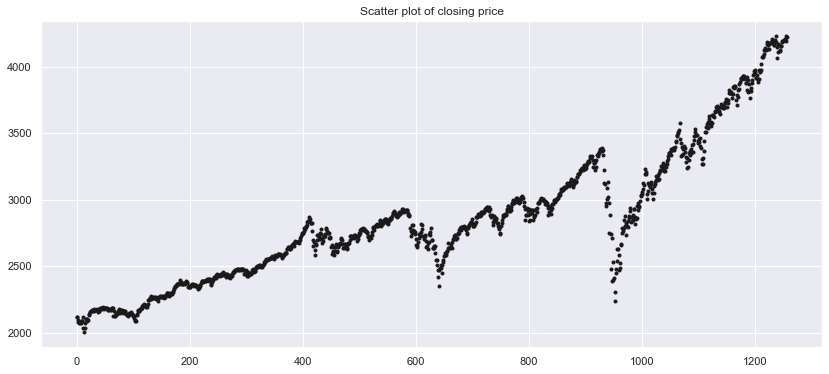

In [307]:
df_close = df['adj_close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

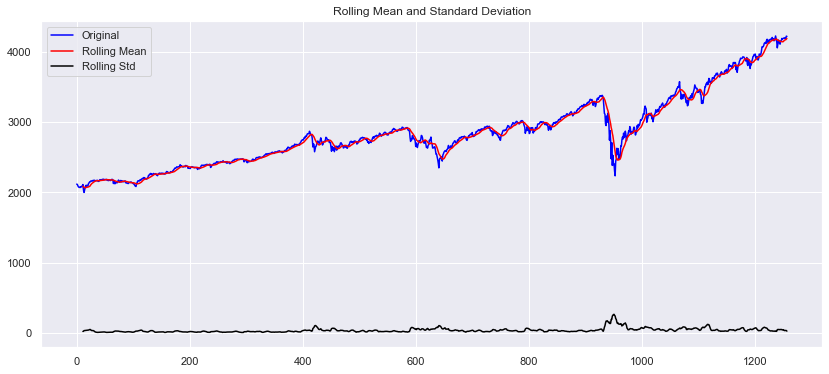

Results of dickey fuller test
Test Statistics                  -0.114882
p-value                           0.947936
No. of lags used                  9.000000
Number of observations used    1248.000000
critical value (1%)              -3.435601
critical value (5%)              -2.863859
critical value (10%)             -2.568004
dtype: float64


In [310]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Data is non-stationary

<ipython-input-312-7d28f8538da7>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_close, model='multiplicative', freq = 30)


<Figure size 1008x432 with 0 Axes>

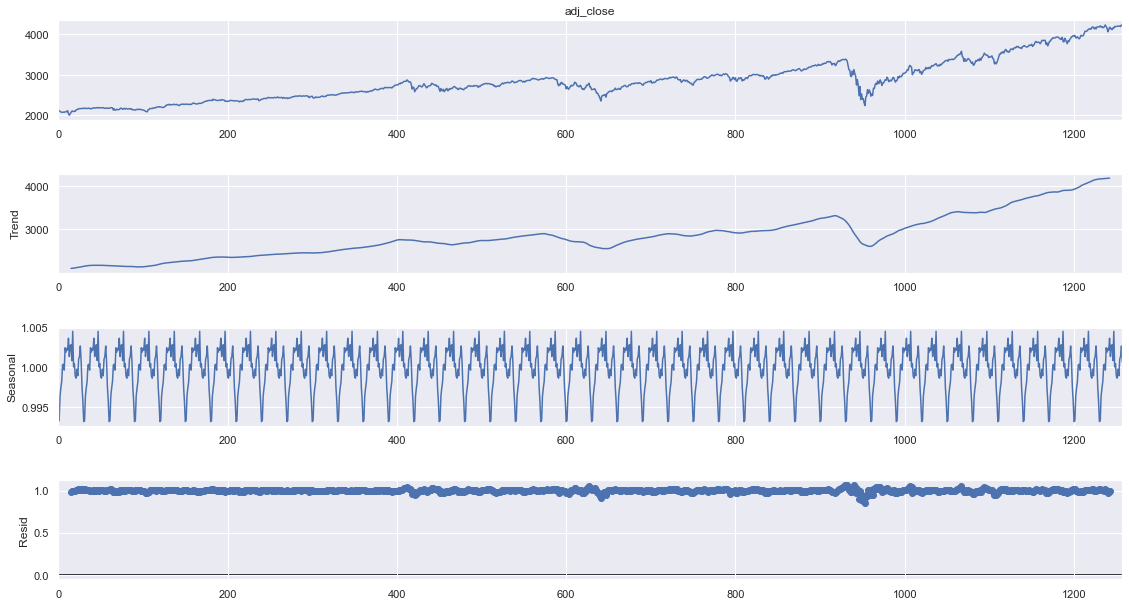

In [312]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Splitting the Raw Data

##  Running Arima

## Running Prophet

## Combining the Time Series Models

## Exporting Dataa to CSV